<a href="https://colab.research.google.com/github/RoetGer/applied-causality-booklet/blob/main/causality_basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basics of Causality in Data Science

---



In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm

from graphviz import Digraph
from IPython.display import Image

plt.rc('figure', figsize=(12, 10))
plt.rc('font', size=16);

## Association vs Causality

A first important milestone in understanding on how causality affects us as data scientists is to acknowledge the difference between association and causality. Or to put it more concisely: "Correlation does not imply causation".

Let's look at some data:

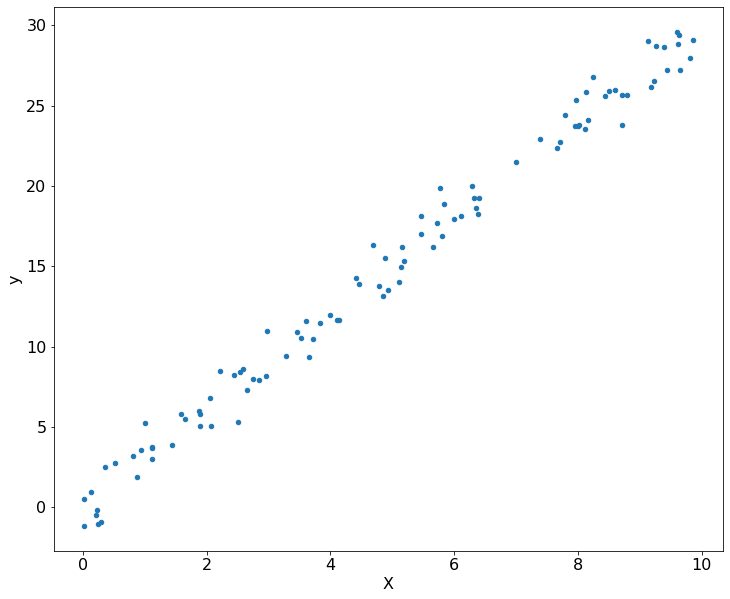

In [38]:
def get_data(effect_size, seed=5):
  np.random.seed(seed)

  x = np.random.uniform(high=10., size=100)
  y = effect_size*x + np.random.normal(size=100)

  return pd.DataFrame({
      'X': x,
      'y': y
  })

data = get_data(effect_size=3.)
data.plot.scatter('X', 'y');

In [39]:
mdl = sm.OLS(endog=data.y, exog=data.X).fit()
mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.996
Model:                            OLS   Adj. R-squared (uncentered):              0.996
Method:                 Least Squares   F-statistic:                          2.770e+04
Date:                Sun, 02 May 2021   Prob (F-statistic):                   5.11e-123
Time:                        21:16:46   Log-Likelihood:                         -145.55
No. Observations:                 100   AIC:                                      293.1
Df Residuals:                      99   BIC:                                      295.7
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
X              3.0030      0.018    166.431      0.000       2.967       3.039
==============================================================================
Omnibus:                        0.710   Durbin-Watson:                   1.660
Prob(Omnibus):                  0.701   Jarque-Bera (JB):                0.829
Skew:                           0.125   Prob(JB):                        0.661
Kurtosis:                       2.630   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

For the sampled dataset it is easy to recover a relationship between X and y. However, we implicitly assumed that y depends on X, although this was not stated anywhere, we could have also regressed X on y, i.e.:

In [40]:
mdl = sm.OLS(endog=data.X, exog=data.y).fit()
mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      X   R-squared (uncentered):                   0.996
Model:                            OLS   Adj. R-squared (uncentered):              0.996
Method:                 Least Squares   F-statistic:                          2.770e+04
Date:                Sun, 02 May 2021   Prob (F-statistic):                   5.11e-123
Time:                        21:16:51   Log-Likelihood:                         -35.411
No. Observations:                 100   AIC:                                      72.82
Df Residuals:                      99   BIC:                                      75.43
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
y              0.3318      0.002    166.431      0.000       0.328       0.336
==============================================================================
Omnibus:                        0.719   Durbin-Watson:                   1.660
Prob(Omnibus):                  0.698   Jarque-Bera (JB):                0.837
Skew:                          -0.126   Prob(JB):                        0.658
Kurtosis:                       2.629   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Based on the get_data function, the first approach is the correct one (we simply multiply X by 3 and then add some noise). However, the data alone cannot tell us which direction is the proper one. Without any assumptions/knowledge about the underlying causal structure, we can only talk about associations, which in case of the linear regression are basically conditional expectations, i.e. $\mathbb{E}[Y|X]$ and $\mathbb{E}[X|Y]$. This gives us the power to answer questions of the nature: "We have observed X, what do we expect to see for Y", e.g.:

* "A customer x has an income of 10.000 Euro, what would we expect this customer spends on leisure articles?"
* "We can see it rain, what is the chance that our driveway is wet?"
* "An applicant for a personal loan works as a teacher, what is the estimated probability that they will default"

In contrast, causality goes beyond merely observing what is happening and tries to infer the concrete impact of one variable onto another one. This would allow us to make statements about what would happen, if we set a variable to a certain value. In the notation developed by Pearl, we would use the do-operator and write: $\mathbb{E}[Y|\text{do}(X)]$ and $\mathbb{E}[X|\text{do}(Y)]$ to differentiate this setting from the classical one, where we just infer associative relationships.

Some questions we might be interested in and which tend to have a causal twist to them:

* "What was the concrete impact of calling the customer in their decision to purchase the service?"
* "If we turn on the sprinkler, what is the chance that the driveway gets wet?"
* "What would the result of my A/B test best, if everyone did what they were supposed to do?" 
* "Which variables do we have to measure in order for us to determine whether an advertisement campaign is worth its money?"




## Basic Building Blocks for Working with Causality

### A Graphical View

One of the core takeaways from Pearl's work is that graphs are a great tool to depict and analyse issues of causality.

As a first step, we can present how we would depict the problem from the previous sections with graphs

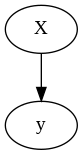

In [41]:
dot = Digraph()

dot.node('X')
dot.node('y')

dot.edges(['Xy'])
dot.render('Xy_relationship', view=True, format='png')
Image('Xy_relationship.png')

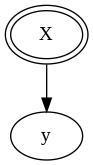

In [42]:
dot = Digraph()

dot.node('X', peripheries='2')
dot.node('y')

dot.edges(['Xy'])
dot.render('Xy_interv', view=True, format='png')
Image('Xy_interv.png')

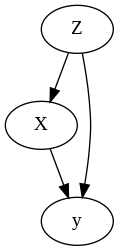

In [43]:
def get_data(seed=5, X_interv=None):
  if seed:
    np.random.seed(seed)
  
  Z = np.random.normal(size=100)
  X_noise = np.random.normal(scale=0.5, size=100)
  
  if not X_interv:
    X = 3. + 1.5*Z + X_noise
  else:
    X = X_interv

  y = 1. + 2.*X + 2.*Z + np.random.normal(scale=0.25, size=100)

  return pd.DataFrame({
      'X': X,
      'y': y,
      'Z': Z
  })

data = get_data(5)

dot = Digraph()

dot.node('X')
dot.node('Z')
dot.node('y')

dot.edges(['Xy', 'ZX', 'Zy'])
dot.render('XZy_relationship', view=True, format='png')
Image('XZy_relationship.png')

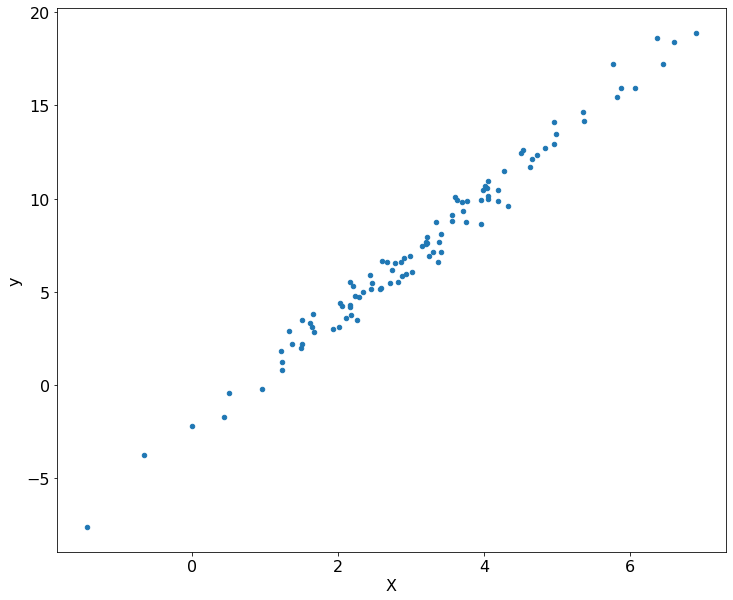

In [44]:
data.plot.scatter('X', 'y')

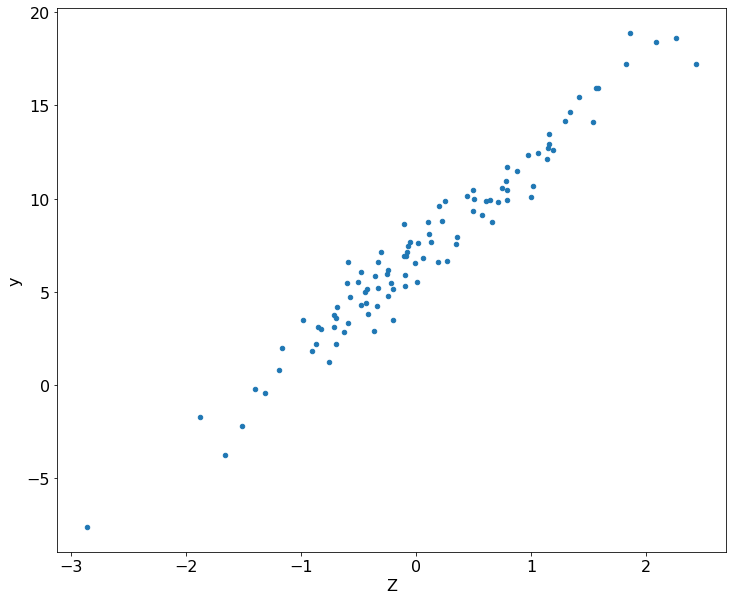

In [45]:
data.plot.scatter('Z', 'y')

In [46]:
mdl = sm.OLS(endog=data.y, exog=sm.add_constant(data.X)).fit()
mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     5553.
Date:                Sun, 02 May 2021   Prob (F-statistic):           4.20e-88
Time:                        21:17:00   Log-Likelihood:                -98.282
No. Observations:                 100   AIC:                             200.6
Df Residuals:                      98   BIC:                             205.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.4149      0.148    -16.353      0.000      -2.708      -2.122
X              3.1325      0.042     74.520      0.000       3.049       3.216
==============================================================================
Omnibus:                        0.313   Durbin-Watson:                   1.911
Prob(Omnibus):                  0.855   Jarque-Bera (JB):                0.486
Skew:                          -0.023   Prob(JB):                        0.784
Kurtosis:                       2.662   Cond. No.                         8.47
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

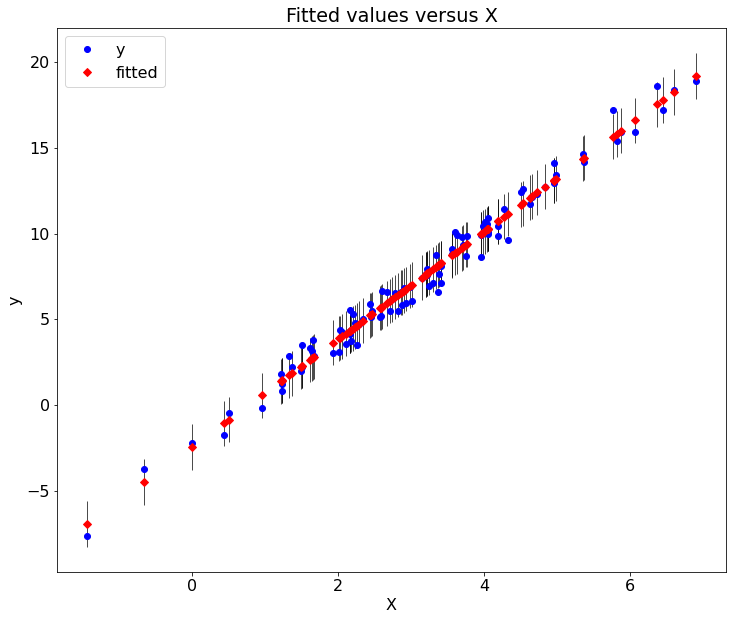

In [47]:
sm.graphics.plot_fit(mdl, exog_idx='X');

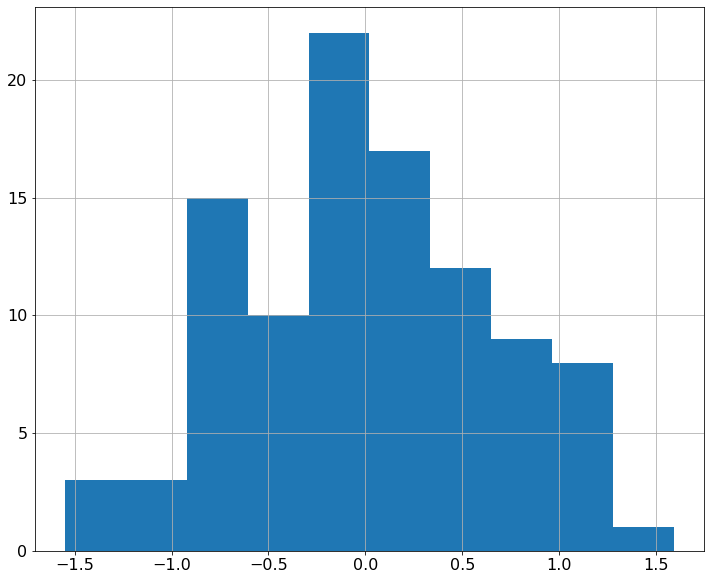

In [48]:
mdl.resid.hist();

The fitted against observed values plots looks ok, while the residual histograms indicates some issues with the normality of the residuals, but nothing too extraordinary. Let us say, for the sake of argument, that everything is fine, that we are interpreting the relationship as a causal one, i.e. X causes y, and that we want to use this new knowledge to control y. Suppose that X=5 is the optimal value to control y, based on our model, we would expect all our values to lie within the following interval:



In [52]:
def get_pi(mdl, pred_df, alpha=0.05):
  predictions = mdl.get_prediction(pred_df)
  pred_intervals = predictions.summary_frame(alpha=alpha)[
    ['obs_ci_lower', 'obs_ci_upper']
  ]

  return pred_intervals.iloc[0]
  
pred_df = sm.add_constant(data['X']).iloc[0]
pred_df.X = 5.

pred_int_low, pred_int_up = get_pi(mdl, pred_df)
pred_int_low, pred_int_up

(11.936056975438753, 14.559322662687315)

However, when we are sampling the data again, now with forcing X to be 5, we get:

In [53]:
data_interv = get_data(X_interv=5.)

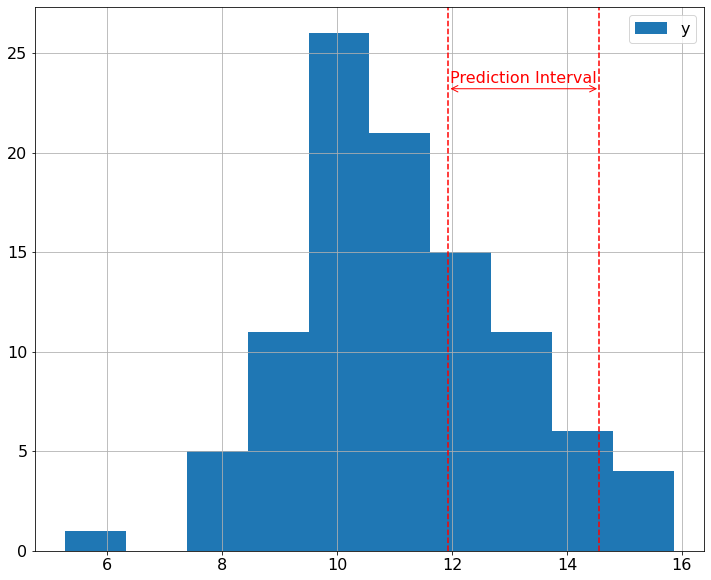

In [54]:
def plot_obs_and_pi(y, pred_int_low, pred_int_up):
  y.hist(legend=True)
  ymax = plt.ylim()[1]

  plt.axvline(x=pred_int_low, ymin=0, ymax=ymax, color='r', linestyle='--')
  plt.axvline(x=pred_int_up, ymin=0, ymax=ymax, color='r', linestyle='--')

  plt.annotate(
      s='', 
      xy=(pred_int_low, ymax*0.85), 
      xytext=(pred_int_up, ymax*0.85),
      arrowprops={'arrowstyle': '<->', 'color': 'red'})

  plt.text(
      x=(pred_int_low + pred_int_up)/2,
      y=ymax*0.86,
      s='Prediction Interval',
      ha='center',
      color='red')

plot_obs_and_pi(data_interv.y, pred_int_low, pred_int_up)

This looks horrible. However, you might argue that problem arises from not taking into consideration Z. So let's do try this!

In [56]:
mdl = sm.OLS(endog=data.y, exog=sm.add_constant(data[['X', 'Z']])).fit()
mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 2.296e+04
Date:                Sun, 02 May 2021   Prob (F-statistic):          1.60e-130
Time:                        21:22:08   Log-Likelihood:                 7.0929
No. Observations:                 100   AIC:                            -8.186
Df Residuals:                      97   BIC:                           -0.3703
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9305      0.137      6.815      0.000       0.659       1.201
X              2.0133      0.045     44.979      0.000       1.925       2.102
Z              1.9780      0.075     26.478      0.000       1.830       2.126
==============================================================================
Omnibus:                        0.366   Durbin-Watson:                   2.297
Prob(Omnibus):                  0.833   Jarque-Bera (JB):                0.498
Skew:                          -0.127   Prob(JB):                        0.780
Kurtosis:                       2.765   Cond. No.                         25.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Just by looking at the model coefficients and comparing them to the equation used to generate the observations in the get_data function, we can see that we seem to have recovered the relationship between X and y pretty well. But have we also identified the causal magnitude between the two.

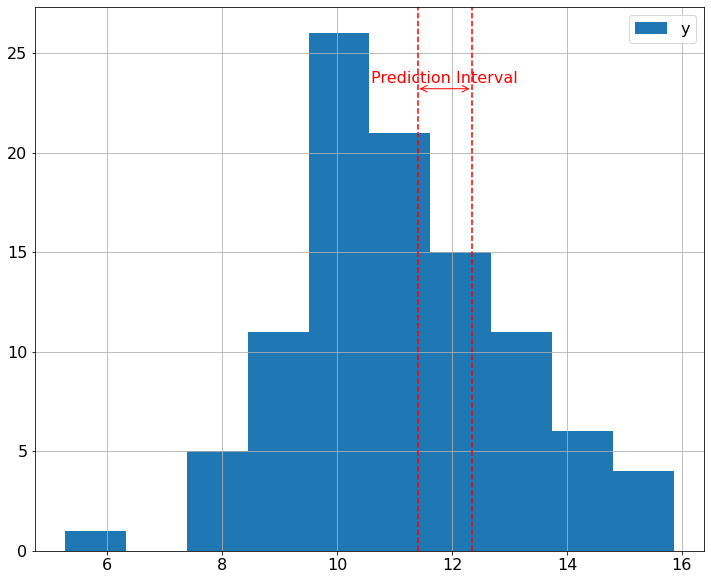

In [59]:
pred_df = sm.add_constant(data[['X', 'Z']]).iloc[0]
pred_df.X = 5.

data_interv = get_data(X_interv=5.)

pred_int_low, pred_int_up = get_pi(mdl, pred_df)

plot_obs_and_pi(data_interv.y, pred_int_low, pred_int_up)

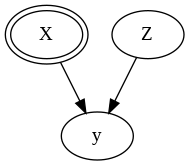

In [16]:
dot = Digraph()

dot.node('X', peripheries='2')
dot.node('Z')
dot.node('y')

dot.edges(['Xy', 'Zy'])
dot.render('XZy_interv', view=True, format='png')
Image('XZy_interv.png')

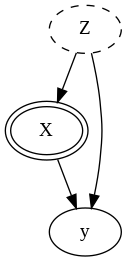

In [17]:
dot = Digraph()

dot.node('X', peripheries='2')
dot.node('Z', style='dashed')
dot.node('y')

dot.edges(['Xy', 'ZX', 'Zy'])
dot.render('XZy_relationship', view=True, format='png')
Image('XZy_relationship.png')

### Two Important Tools

#### Backdoor Criterion

#### Frontdoor Criterion